# Composites of Correctly Identified Top Snow and All Top Snow Days

In [2]:
import xarray as xr 
import cartopy.crs as ccrs
import matplotlib.path as mpath
import cartopy.feature as cfeature
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import colorsys
#plot parameters that I personally like, feel free to make these your own.
import matplotlib
import matplotlib.patheffects as path_effects

#outlines for text 
pe1 = [path_effects.withStroke(linewidth=1.5,
                             foreground="k")]
pe2 = [path_effects.withStroke(linewidth=1.5,
                             foreground="w")]

matplotlib.rcParams['axes.facecolor'] = [0.9,0.9,0.9] #makes a grey background to the axis face
matplotlib.rcParams['axes.labelsize'] = 14 #fontsize in pts
matplotlib.rcParams['axes.titlesize'] = 14 
matplotlib.rcParams['xtick.labelsize'] = 12 
matplotlib.rcParams['ytick.labelsize'] = 12 
matplotlib.rcParams['legend.fontsize'] = 12 
matplotlib.rcParams['legend.facecolor'] = 'w' 
matplotlib.rcParams['savefig.transparent'] = False

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'
colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
from scipy.ndimage import gaussian_filter


## Correctly Identified Top Snow Days Centered Composites

In [20]:
r = 4
color_map = ['#980000','#980000', '#CC0200','#CC0200', '#FF0300','#FF0300', '#FF6564','#FF6564','#FFCDCD','#FFCDCD', '#FFFFFF','#FFFFFF', '#E1E1FF','#E1E1FF', '#6565FF','#6565FF', '#2600FF',  '#2600FF', '#1800B6', '#1800B6', '#0A006E', '#0A006E']


In [21]:

name = 'Final'
cutoff =.45
file_path = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'
inputs = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/final_test_ds.nc', chunks = 'auto')
inputs = inputs.where(inputs.n_channel.isin(['V','IWV', 'SLP', 'H']), drop = True)
results = pd.read_csv(file_path+name+'_preds.csv', index_col = 0)
predict = results.where(results>=.45, 0)
predict = predict.where(predict==0, 1)
test = pd.read_csv(file_path+name+'_test.csv', index_col = 0)
titles = np.array(inputs.n_channel.values)
tp_id = [np.where((predict[str(r)]==1) & (test[str(r)]==1))[0] for r in range(5)]
inputs_regionalTP = inputs.isel(time = tp_id[r])
basins_slice_start = [-72,  0,  72,  144, -144]
basins_slice_end = [ 71.5, 143.5, 216, 288,  -.5]
inputs_regionalTP = inputs_regionalTP.drop_vars('labels')
if r ==2 or r ==3:
    inputs_regionalTP= inputs_regionalTP.assign_coords({'lon' :('lon',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    inputs_regionalTP= inputs_regionalTP.sortby('lon')
inputs_regionalTP = inputs_regionalTP.sel(lon = slice(basins_slice_start[r],basins_slice_end[r])).load()

precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))

slice_start = np.array([-36, 36, 108, 180 , -108])
slice_end = np.array([36, 108, 180, 252, -36])
region_lons = inputs_regionalTP.sel(lon = slice(slice_start[r], slice_end[r])).lon.values

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-80,-40)).load()
if r==2 or r == 3:
    basins = basins.assign_coords({'lon' :('lon',np.concatenate([np.arange(180,360,.625),np.arange(0,180,.625)]))})
    basins = basins.sortby('lon')
basins = basins.Zwallybasins == 0
basins = basins.sel(lon  = slice(basins_slice_start[r], basins_slice_end[r]))


In [22]:
precip_weights = np.array(pd.read_csv('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Precip/TP_precip_weights_region'+str(r)+'.csv', index_col = 0))
len_shifted_weights = 230

shifted_V= np.empty((len(inputs_regionalTP.time), len(inputs_regionalTP.lat), len_shifted_weights))
shifted_V[:,:,:] = np.nan
shifted_IWV= np.empty((len(inputs_regionalTP.time), len(inputs_regionalTP.lat), len_shifted_weights))
shifted_IWV[:,:,:] = np.nan
shifted_SLP= np.empty((len(inputs_regionalTP.time), len(inputs_regionalTP.lat), len_shifted_weights))
shifted_SLP[:,:,:] = np.nan
shifted_H= np.empty((len(inputs_regionalTP.time), len(inputs_regionalTP.lat), len_shifted_weights))
shifted_H[:,:,:] = np.nan

for t in range(len(inputs_regionalTP.time)):
    timestamp = str(pd.to_datetime(inputs_regionalTP.isel(time = t).time.values).year) + "%02d"%pd.to_datetime(inputs_regionalTP.isel(time = t).time.values).month+"%02d"%pd.to_datetime(inputs_regionalTP.isel(time = t).time.values).day
    max_id = int(np.where(precip_weights[t] == precip_weights[t].max())[0])
    trim_data = inputs_regionalTP.sel(lon = slice(region_lons[max_id] - 36, region_lons[max_id] + 36)).isel(time = t)
    trim_basins = basins.sel(lon = slice(region_lons[max_id] - 36, region_lons[max_id] + 36))
    max_id_data = int(np.where(trim_data.lon.values == region_lons[max_id])[0])
    
    trim_V = np.where(trim_basins, trim_data.sel(n_channel = 'V').features, 0)
    shifted_V[t][:,(115-max_id_data):(230-max_id_data)] = trim_V
    trim_IWV = np.where(trim_basins, trim_data.sel(n_channel = 'IWV').features, 0)
    shifted_IWV[t][:,(115-max_id_data):(230-max_id_data)] = trim_IWV    
    trim_SLP = np.where(trim_basins, trim_data.sel(n_channel = 'SLP').features, 0)
    shifted_SLP[t][:,(115-max_id_data):(230-max_id_data)] = trim_SLP
    trim_H = np.where(trim_basins, trim_data.sel(n_channel = 'H').features, 0)
    shifted_H[t][:,(115-max_id_data):(230-max_id_data)] = trim_H

plot_data = [np.nanmean(shifted_V, 0),
             np.nanmean(shifted_IWV, 0),
             np.nanmean(shifted_SLP, 0),
             np.nanmean(shifted_H, 0),
            ]

/tmp/ipykernel_748949/98268934.py:29: RuntimeWarning: Mean of empty slice
  plot_data = [np.nanmean(shifted_V, 0),
/tmp/ipykernel_748949/98268934.py:30: RuntimeWarning: Mean of empty slice
  np.nanmean(shifted_IWV, 0),
/tmp/ipykernel_748949/98268934.py:31: RuntimeWarning: Mean of empty slice
  np.nanmean(shifted_SLP, 0),
/tmp/ipykernel_748949/98268934.py:32: RuntimeWarning: Mean of empty slice
  np.nanmean(shifted_H, 0),


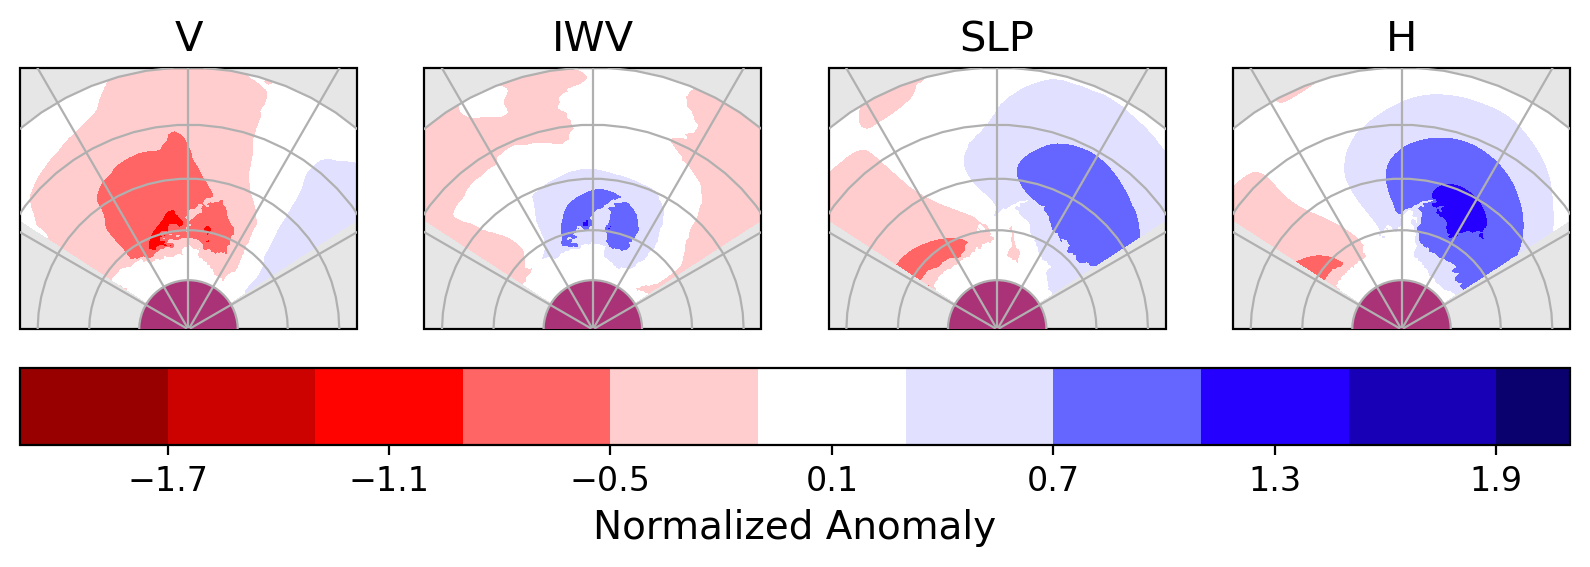

In [23]:
fig, axes=plt.subplots(ncols=4,nrows=1,figsize=(10,5),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax = axes.flatten()
for a in ax:
    a.set_extent([-40, 40, -90, -40], ccrs.PlateCarree())
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30

    a.contourf(np.arange(-115,115,1), np.arange(-90, -79.5, .5), np.ones((21, 230)), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree(), zorder = 11)
    titles = ['V', 'IWV', 'SLP','H']
levels = np.arange(-2.1,2.2,.2)
for v in range(4):
    cf = ax[v].contourf(np.arange(-115,115,1), basins.lat.values, plot_data[v],  levels = levels, colors = color_map, transform=ccrs.PlateCarree())
    ax[v].set_title(titles[v], size = 15) 
cbar = fig.colorbar(cf,orientation = 'horizontal', ax = axes.ravel(), pad = .05, )#ticks =np.arange(-1,1.2,.2))
# cbar.ax.set_xticklabels([-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]) 
cbar.set_label('Normalized Anomaly')
plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/TP_centered_composite_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')


## All Top Snow timesteps Centered Composites

### 1. calculate precip weights for all top snow using Calculate_precip_weights.py
### 2. calculate centered composites using Calculate_centered_composites_alltopsnow.py




In [74]:
r = 4
composite_folder = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/Centered_Results/AllTopSnow_'
plot_data = [np.array(pd.read_csv(composite_folder+'V_Region'+str(r), index_col = False)),
             np.array(pd.read_csv(composite_folder+'IWV_Region'+str(r), index_col = False)),
             np.array(pd.read_csv(composite_folder+'SLP_Region'+str(r), index_col = False)),
             np.array(pd.read_csv(composite_folder+'H_Region'+str(r), index_col = False))   
]

lats = np.array([-80. , -79.5, -79. , -78.5, -78. , -77.5, -77. , -76.5, -76. ,
       -75.5, -75. , -74.5, -74. , -73.5, -73. , -72.5, -72. , -71.5,
       -71. , -70.5, -70. , -69.5, -69. , -68.5, -68. , -67.5, -67. ,
       -66.5, -66. , -65.5, -65. , -64.5, -64. , -63.5, -63. , -62.5,
       -62. , -61.5, -61. , -60.5, -60. , -59.5, -59. , -58.5, -58. ,
       -57.5, -57. , -56.5, -56. , -55.5, -55. , -54.5, -54. , -53.5,
       -53. , -52.5, -52. , -51.5, -51. , -50.5, -50. , -49.5, -49. ,
       -48.5, -48. , -47.5, -47. , -46.5, -46. , -45.5, -45. , -44.5,
       -44. , -43.5, -43. , -42.5, -42. , -41.5, -41. , -40.5, -40. ])

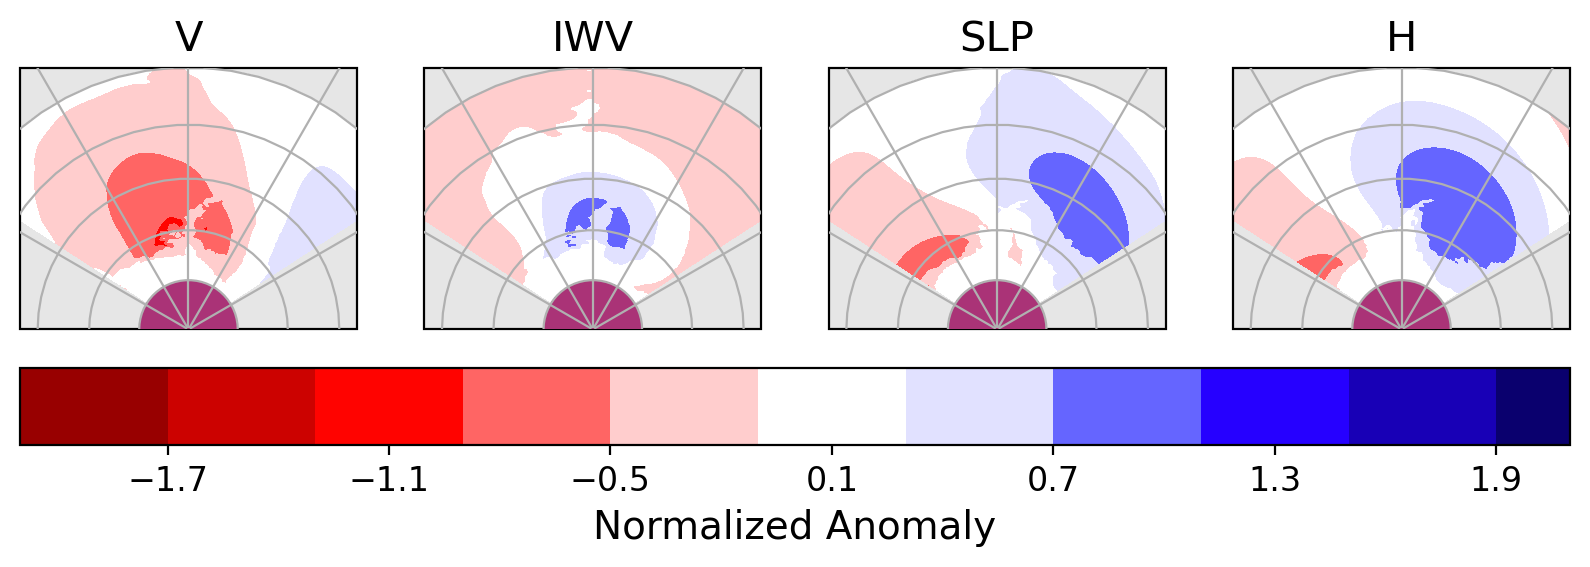

In [75]:
fig, axes=plt.subplots(ncols=4,nrows=1,figsize=(10,5),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax = axes.flatten()
for a in ax:
    a.set_extent([-40, 40, -90, -40], ccrs.PlateCarree())
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30

    a.contourf(np.arange(-115,115,1), np.arange(-90, -79.5, .5), np.ones((21, 230)), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), transform=ccrs.PlateCarree(), zorder = 11)
    titles = ['V', 'IWV', 'SLP','H']
levels = np.arange(-2.1,2.2,.2)
for v in range(4):
    cf = ax[v].contourf(np.arange(-115,115,1), lats, plot_data[v],  levels = levels, colors = color_map, transform=ccrs.PlateCarree())
    ax[v].set_title(titles[v], size = 15) 
cbar = fig.colorbar(cf,orientation = 'horizontal', ax = axes.ravel(), pad = .05, )#ticks =np.arange(-1,1.2,.2))
# cbar.ax.set_xticklabels([-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]) 
cbar.set_label('Normalized Anomaly')
plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/allTopSnow_composite_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')


## Correctly Identified Top Snow Days Non Centered Composites

In [2]:
name = 'Final'
cutoff =.45
file_path = '/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/CNN_retry_2V/'
inputs = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/CNN_retry/final_test_ds.nc')
inputs = inputs.where(inputs.n_channel.isin(['V','IWV', 'SLP', 'H']), drop = True)
results = pd.read_csv(file_path+name+'_preds.csv', index_col = 0)
predict = results.where(results>=.45, 0)
predict = predict.where(predict==0, 1)
test = pd.read_csv(file_path+name+'_test.csv', index_col = 0)
titles = np.array(inputs.n_channel.values)

In [3]:
tp_id = [np.where((predict[str(r)]==1) & (test[str(r)]==1))[0] for r in range(5)]

In [21]:
r = 3
inputs_regionalTP = inputs.isel(time = tp_id[r])
inputs_regionalTP_composite = inputs_regionalTP.features.mean(dim = 'time').load()

#load maps
ocean_50m = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',edgecolor='lightblue',facecolor='lightblue') # 10m, 50m, 110m # edgecolor lightblue
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',edgecolor='none',facecolor='white') # 10m, 50m, 110m
ice_shelf_poly = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_polys', '50m',edgecolor='none',facecolor='white') # 10m, 50m, 110m
ice_shelf_line = cfeature.NaturalEarthFeature('physical', 'antarctic_ice_shelves_lines', '50m',edgecolor='black',facecolor='none') # 10m, 50m, 110m

basins = xr.open_mfdataset('/pl/active/ATOC_SynopticMet/data/ar_data/Research3/Data/AIS_basins_Zwally_MERRA2grid.nc').sel(lat = slice(-90,-60)).load()
basins = basins.Zwallybasins > 0

slice_start = np.array([-36, 36, 108, -180 , -108])
slice_end = slice_start + 72

colors = ['#F6A5AE', '#228833', '#4577AA','#67CCED', '#AA3377']
color_map = ['#980000','#980000', '#CC0200','#CC0200', '#FF0300','#FF0300', '#FF6564','#FF6564','#FFCDCD','#FFCDCD', '#FFFFFF','#FFFFFF', '#E1E1FF','#E1E1FF', '#6565FF','#6565FF', '#2600FF',  '#2600FF', '#1800B6', '#1800B6', '#0A006E', '#0A006E']
color_map_r = [ '#0A006E', '#0A006E','#1800B6', '#1800B6', '#2600FF',  '#2600FF',  '#6565FF','#6565FF','#E1E1FF','#E1E1FF','#FFFFFF','#FFFFFF', '#FFCDCD','#FFCDCD', '#FF6564','#FF6564', '#FF0300','#FF0300', '#CC0200','#CC0200','#980000','#980000',]



In [22]:
titles = ['V','IWV','SLP','H']

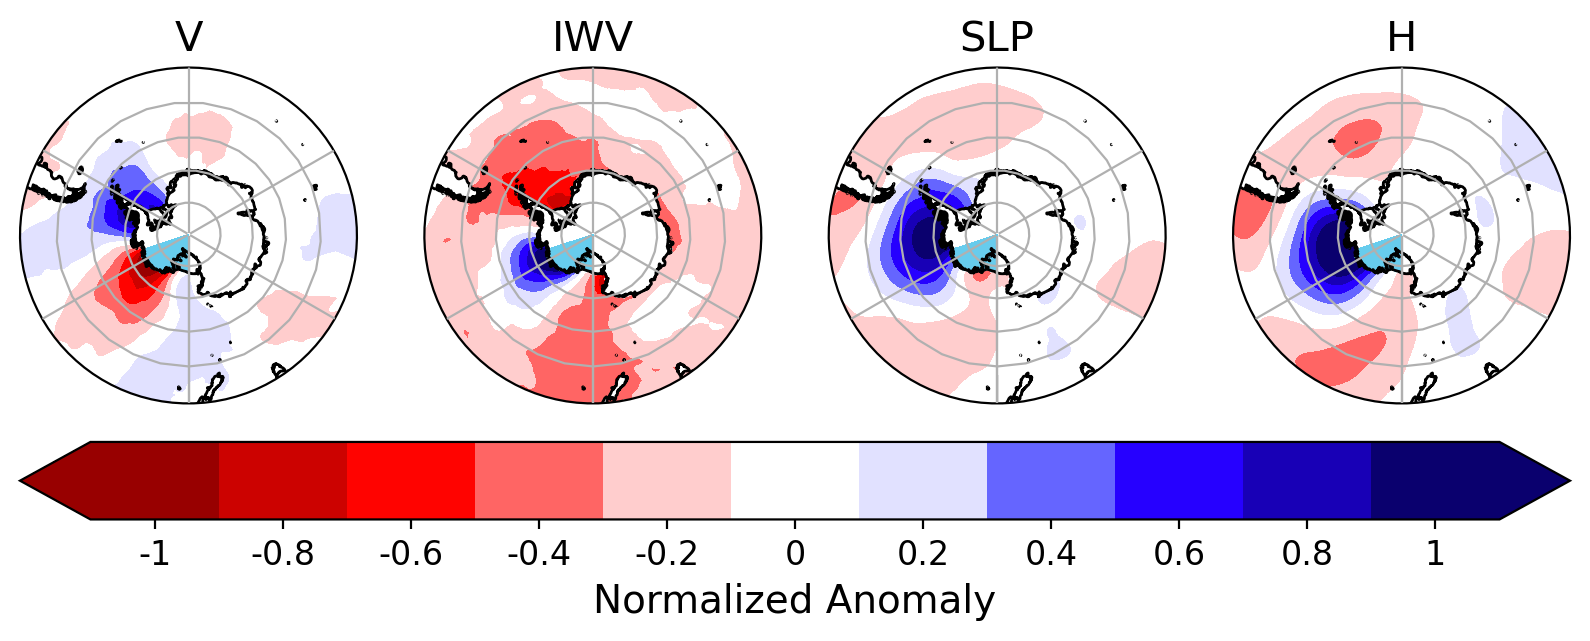

In [23]:
fig, axes=plt.subplots(ncols=4,nrows=1,figsize=(10,5),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax = axes.flatten()
for a in ax:
    a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    a.set_boundary(circle, transform=a.transAxes)
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30
    a.add_feature(land_50m)
    a.add_feature(ice_shelf_poly)
    a.add_feature(ice_shelf_line, linewidth = 1,zorder = 13)
    a.coastlines(resolution='50m', linewidth = 1,zorder = 13)
    slice_data = basins.sel(lon  = slice(slice_start[r], slice_end[r]))
    a.contourf(slice_data.lon, slice_data.lat, xr.where(slice_data.values==True,1,0), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), 
               transform=ccrs.PlateCarree(), zorder = 12)

for v in range(4):
    cf = ax[v].contourf(inputs_regionalTP_composite.lon, inputs_regionalTP_composite.lat, gaussian_filter(inputs_regionalTP_composite.sel(n_channel = titles[v]), .5), 
                          colors = color_map,levels = np.arange(-1.1,1.2,.1), extend = 'both', transform=ccrs.PlateCarree())

    ax[v].set_title(inputs_regionalTP_composite.sel(n_channel = titles[v]).n_channel.values, size = 15) 
cbar = fig.colorbar(cf,orientation = 'horizontal', ax = axes.ravel(), pad = .05, ticks =np.arange(-1,1.2,.2))
cbar.ax.set_xticklabels([-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]) 
cbar.set_label('Normalized Anomaly')
# plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/TP_composite_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')


In [24]:
titles = ['SLP','H']

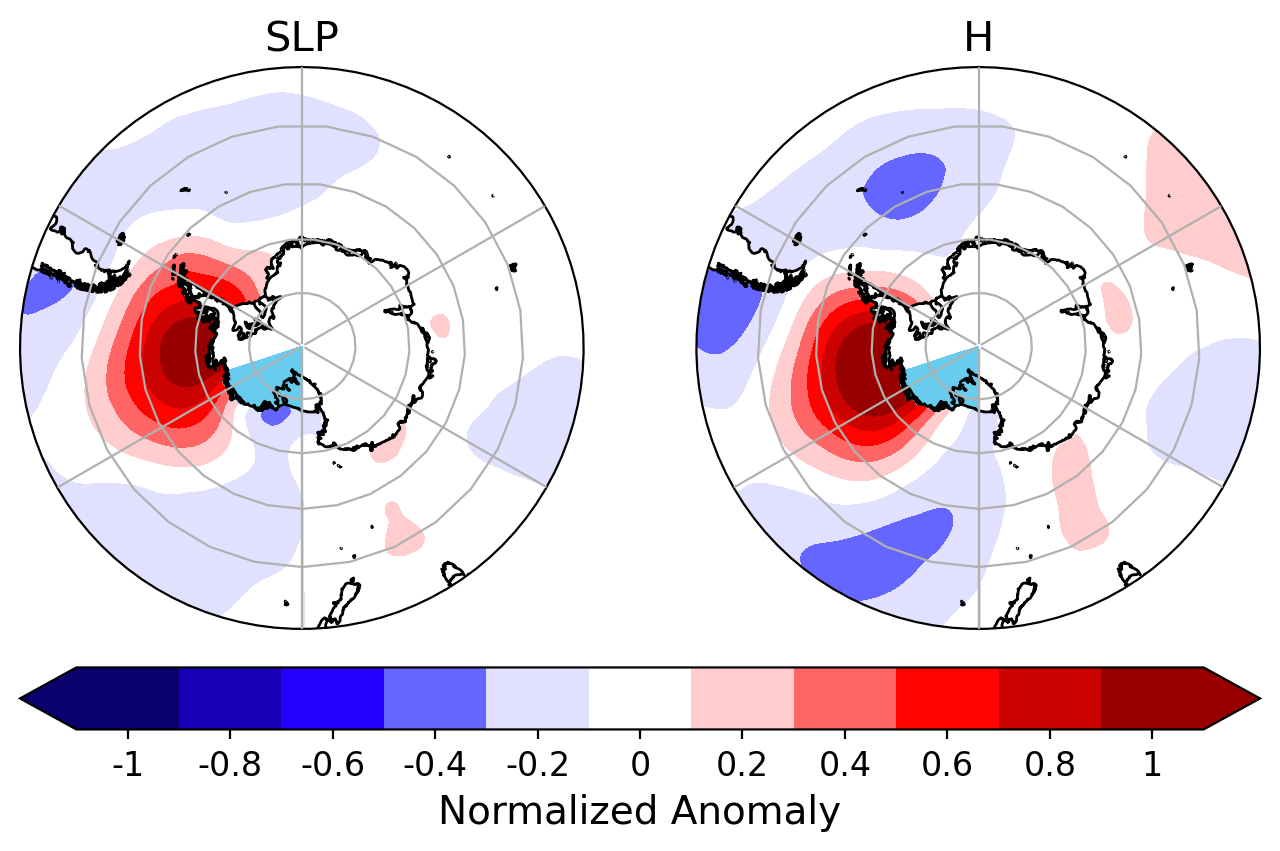

In [25]:
fig, axes=plt.subplots(ncols=2,nrows=1,figsize=(8,5),subplot_kw={'projection': ccrs.SouthPolarStereo(central_longitude=0)})
ax = axes.flatten()
for a in ax:
    a.set_extent([-180, 180, -90, -40], ccrs.PlateCarree())
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)

    a.set_boundary(circle, transform=a.transAxes)
    grid=a.gridlines(zorder = 20)
    grid.n_steps=30
    a.add_feature(land_50m)
    a.add_feature(ice_shelf_poly)
    a.add_feature(ice_shelf_line, linewidth = 1,zorder = 13)
    a.coastlines(resolution='50m', linewidth = 1,zorder = 13)
    slice_data = basins.sel(lon  = slice(slice_start[r], slice_end[r]))
    a.contourf(slice_data.lon, slice_data.lat, xr.where(slice_data.values==True,1,0), levels = np.arange(-.5,1.5,.75),cmap = ListedColormap([ 'None', colors[r]]), 
               transform=ccrs.PlateCarree(), zorder = 12)

for v in range(2):
    cf = ax[v].contourf(inputs_regionalTP_composite.lon, inputs_regionalTP_composite.lat, gaussian_filter(inputs_regionalTP_composite.sel(n_channel = titles[v]), .5), 
                          colors = color_map_r,levels = np.arange(-1.1,1.2,.1), extend = 'both', transform=ccrs.PlateCarree())

    ax[v].set_title(inputs_regionalTP_composite.sel(n_channel = titles[v]).n_channel.values, size = 15) 
cbar = fig.colorbar(cf,orientation = 'horizontal', ax = axes.ravel(), pad = .05, ticks =np.arange(-1,1.2,.2))
cbar.ax.set_xticklabels([-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1]) 
cbar.set_label('Normalized Anomaly')
plt.savefig('/projects/reba1583/Research3/AntarcticAR_ML/NeuralAdditiveModel/tests/precip/CNN_retry_2V/Figures/TP_composite_SLP_H_region'+str(r)+'.png', dpi = 300, transparent = True, bbox_inches = 'tight')
